# ADC 2024 starter notebook 

This baseline notebook is designed to offer a starting point for the competiters. Please note that the approach we've taken is not *THE* solution — it's simply ONE possible approach. Our aim is to assist participants in exploring different ways to preprocess and model the data. Please feel free to fork the notebook and save the model/data for your own exploration.



This notebook was prepared by Virginie Batista and Angèle Syty from the Institut d'Astrophysique de Paris, and Orphée Faucoz from Centre National d’Etudes Spatiales (CNES), with support from Gordon Yip and Tara Tahseen from University College London.

# READ THIS BEFORE YOU PROCEED
This training procedure uses the light dataset produced from this [notebook (Version 5)](https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data). We applied all the calibration steps EXCEPT Linearity Correction with Chunksize = 1. The binned dataset is available to download [here](https://www.kaggle.com/datasets/gordonyip/binned-dataset-v3/data). *If you want to carry out all the correction, you will have to do so yourself.*


**This notebook will only provide the model checkpoints, you are welcomed to use these checkpoints with your own script and submit to the leaderboard.** 

## Task overview

The challenge's primary objective is to process these exposures to produce a single, clean spectrum for each exoplanet, summarizing the rp/rs values across all wavelengths.

The exposure are subject to noises and the images or spectrum are not perfect. The Jitter noise has a complex signature that the ML model should recognize to produce a better spectra.

Different techniques are possible and are up to the participant imagination to produce a novel (and hopefully better) solution to this task.

Here outline our baseline approach :

We first fit  a 1D CNN to fit the mean value of the transmission spectra, taking as input the transit white curve (total flux of each image taken as a function of time).

For the second part of the baseline, to retrieve the atmopsheric features, we make the data lighter by summing up the fluxes along the y-axis, for each wavelength, resulting in 2D images of dimension (N_times, N_wavelengths). We also cut the signal to remove the out of transit in order to enhance transit depth variations between wavelengths. For the same reason, we substract the mean flux, corresponding to the average transit depth, to keep only wavelength variations around this mean. We use a 2D CNN to fit the atmospheric features. 


In [1]:
import os
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

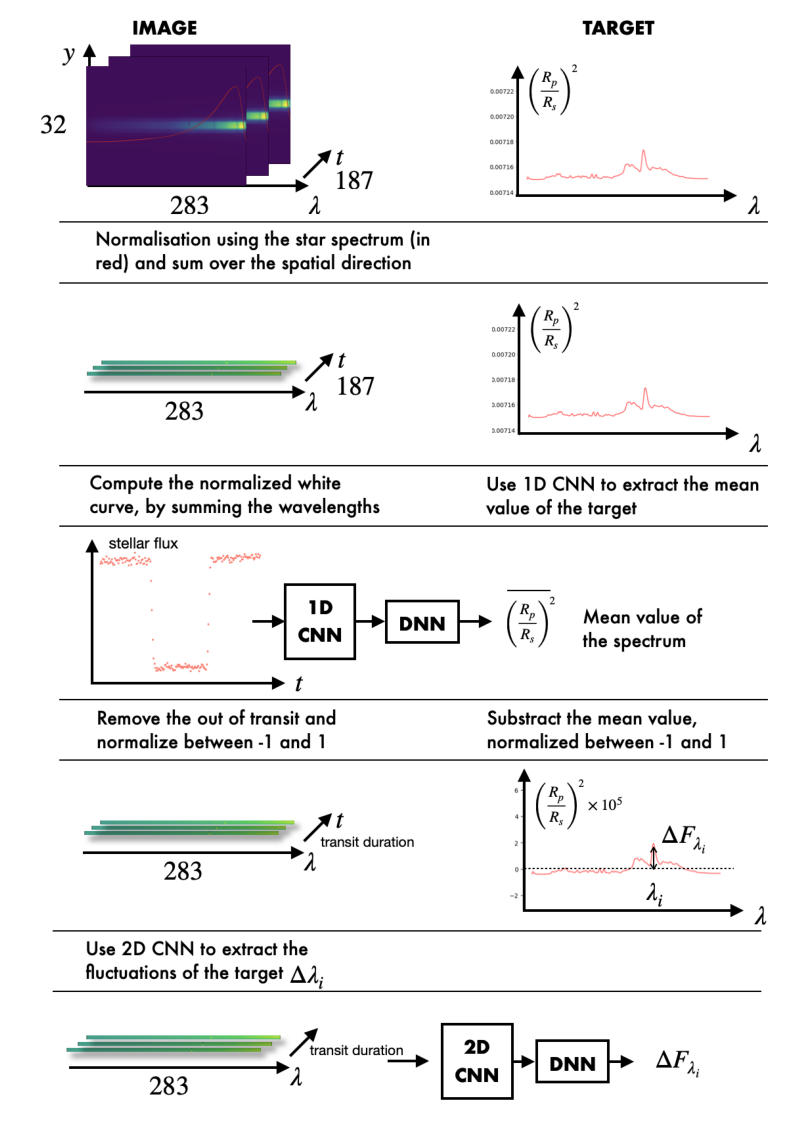

In [2]:
# TODO
img = mpimg.imread("../dataset/baseline-img/2nd_baseline.png")
plt.figure(figsize=(10, 15))
plt.imshow(img)
plt.axis("off")
plt.show()

# Setup Paths and Read Data

In [3]:
# path to the folder containing the data
data_folder = "../dataset/binned-data/"

# path to the folder containing the train targets and wavelengths information
auxiliary_folder = "../dataset/ariel-data-challenge-2024/"

# load the data
data_train = np.load(f"{data_folder}/data_train.npy")
data_train_FGS = np.load(f"{data_folder}/data_train_FGS.npy")
# data_train.shape: (673, 187, 282, 32)
# data_train_FGS.shape: (673, 187, 32, 32)

We create a directory to save the outputs of this notebook, and define the hyperparameters of the model

In [4]:
output_dir = "../output"

SEED = 42

do_the_mcdropout_wc = True
do_the_mcdropout = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

Directory ../output already exists.


# 1D-CNN for mean transit depth

## Preprocessing for 1D CNN

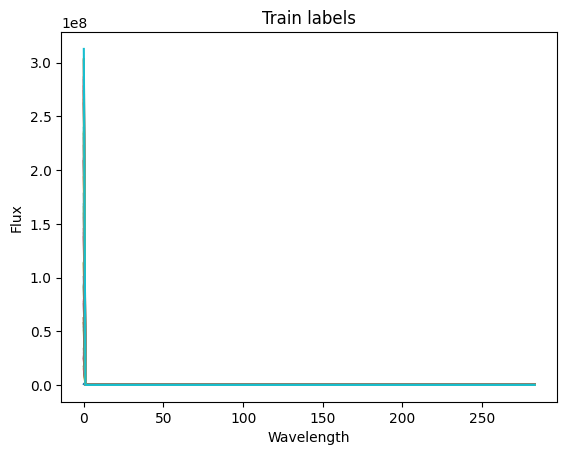

In [5]:
train_solution = np.loadtxt(
    f"{auxiliary_folder}/train_labels.csv", delimiter=",", skiprows=1
)

# targets:
# exclude the first column from the train_solution, because that column represents the baseline or overall flux
# which might not be needed when predicting the detailed wavelength-dependent features.
#
# The remaining length of 283 matches the length of one training sample label.
targets = train_solution[:, 1:]
# train_solution.shape: (673, 284)
# targets.shape: (673, 283)

for i in range(50):
    plt.plot(train_solution[i, :])

plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.title("Train labels")
plt.show()

In [6]:
# targets_mean:
# The mean of the values in each wavelengths of `targets`, excluding the first column (FGS1)
# Used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve
targets_mean = targets[:, 1:].mean(axis=1)
# targets_mean.shape: (673,)

N = targets.shape[0]

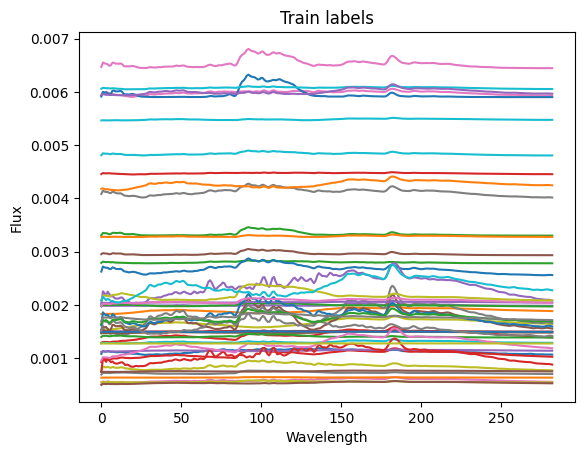

In [7]:
for i in range(50):
    plt.plot(targets[i, :])

plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.title("Train labels")
plt.show()

We create the dataset by adding the FGS frame, crushed in one column, at the end of the AIRS data cube.  
The images are normalized using the star spectrum extracted from the images themselves.

In [8]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned = (
    data_train,
    data_train_FGS,
)
# signal_AIRS_diff_transposed_binned.shape: (673, 187, 282, 32)
# signal_FGS_diff_transposed_binned.shape: (673, 187, 32, 32)

FGS_column = signal_FGS_diff_transposed_binned.sum(axis=2)
# FGS_column.shape: (673, 187, 32)

dataset = np.concatenate(
    [signal_AIRS_diff_transposed_binned, FGS_column[:, :, np.newaxis, :]], axis=2
)

# dataset.shape: (673, 187, 283, 32)

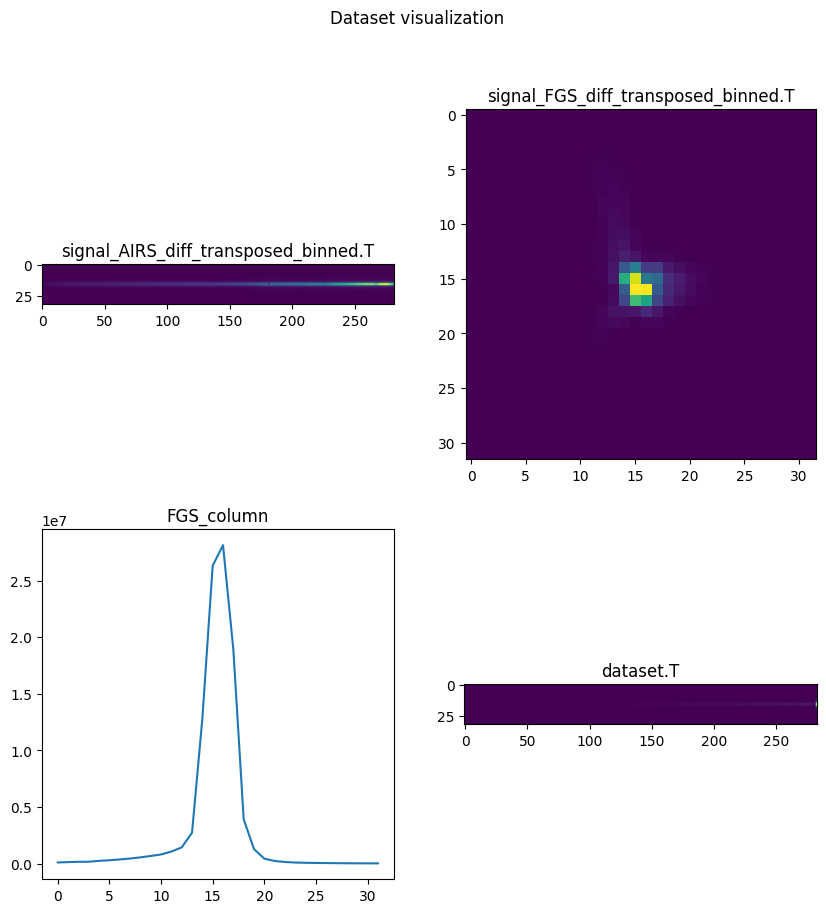

In [9]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Dataset visualization")

ax1 = plt.subplot(2, 2, 1)
ax1.imshow(signal_AIRS_diff_transposed_binned[0, 0, :, :].T)
ax1.set_title("signal_AIRS_diff_transposed_binned.T")

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(signal_FGS_diff_transposed_binned[0, 0, :, :].T)
ax2.set_title("signal_FGS_diff_transposed_binned.T")

# TODO: FGS_column has higher magnitude values
ax3 = plt.subplot(2, 2, 3)
ax3.plot(FGS_column[0, 0, :])
ax3.set_title("FGS_column")

ax4 = plt.subplot(2, 2, 4)
ax4.imshow(dataset[0, 0, :, :].T)
ax4.set_title("dataset.T")

# set figure size
plt.show()

we sum up the pixels on the y-axis to transform the data into 2D images

In [10]:
# squashing the the pixels dimension
dataset = dataset.sum(axis=3)
# dataset.shape: (673, 187, 283)

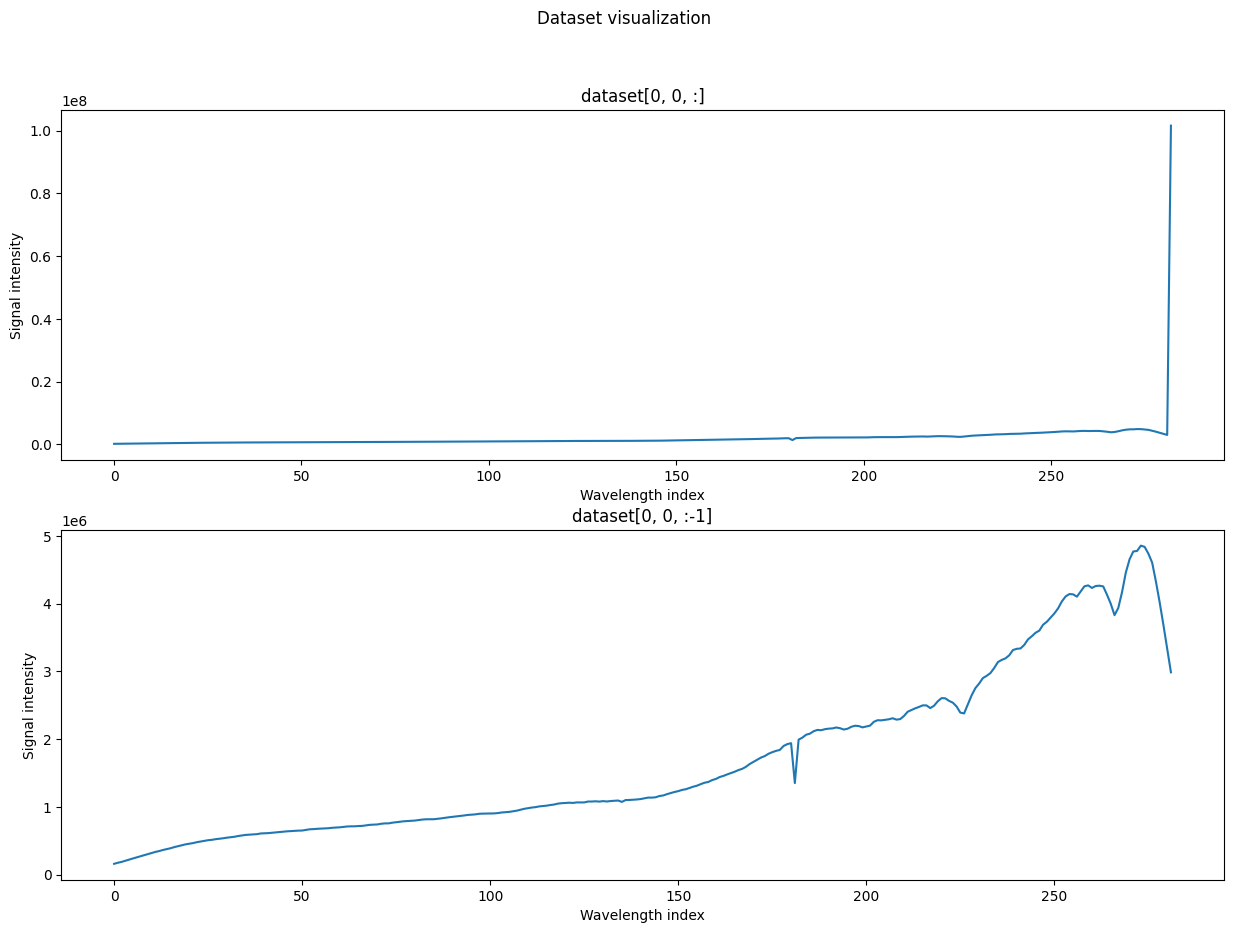

In [11]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Dataset visualization")

ax1 = plt.subplot(2, 1, 1)
ax1.plot(dataset[0, 0, :])
ax1.set_title("dataset[0, 0, :]")
ax1.set_xlabel("Wavelength index")
ax1.set_ylabel("Signal intensity")

ax2 = plt.subplot(2, 1, 2)
ax2.plot(dataset[0, 0, :-1])
ax2.set_title("dataset[0, 0, :-1]")
ax2.set_xlabel("Wavelength index")
ax2.set_ylabel("Signal intensity")

plt.show()

We divide the images by the star flux assuming the first and last 50 instants belong to the out of transit. 

In [12]:
# TODO: this function is not used
def create_dataset_norm(dataset1, dataset2):
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2


def norm_star_spectrum(signal):
    # This function assumes that the fist and last 50 time step bins belong to the out of transit
    #   1. Calculate the sum of the mean of the first and last 50 time step bins
    #   2. Normalize the all time step
    img_star = signal[:, :50].mean(axis=1) + signal[:, -50:].mean(axis=1)
    return signal / img_star[:, np.newaxis, :]


# dataset.shape: (673, 187, 283)
# total 673 number of observations, each with 187 time step bins and 283 wavelength total flux values
dataset_norm = norm_star_spectrum(dataset)
dataset_norm = np.transpose(dataset_norm, (0, 2, 1))
# dataset_norm.shape: (673, 283, 187)

## Split the targets and observations between valid and train

We start by computing a "white curve", that is actually the sum of the signal over the all image, as a function of time. We split the data and normalize the train/valid/test data.

In [13]:
# we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data file
cut_inf, cut_sup = (39, 321)
l = cut_sup - cut_inf + 1
wls = np.arange(l)


def split(data, N):
    list_planets = random.sample(range(0, data.shape[0]), N)
    list_index_1 = np.zeros(data.shape[0], dtype=bool)
    for planet in list_planets:
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1


# N = 673
N_train = 8 * N // 10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
# train_obs.shape: (538, 283, 187)
# valid_obs.shape: (135, 283, 187)
# list_index_train.shape: (673,)

In [14]:
# signal_AIRS_diff_transposed_binned.shape: (673, 187, 282, 32)
signal_AIRS_diff_transposed_binned_sum3 = signal_AIRS_diff_transposed_binned.sum(axis=3)

# signal_AIRS_diff_transposed_binned_sum3.shape: (673, 187, 282)
wc_mean = signal_AIRS_diff_transposed_binned_sum3.mean(axis=1).mean(axis=1)
# wc_mean.shape: (673,) - mean of the white curve for each observation

# normalize the white curve
white_curve = (
    signal_AIRS_diff_transposed_binned_sum3.sum(axis=2) / wc_mean[:, np.newaxis]
)

del signal_AIRS_diff_transposed_binned_sum3, signal_AIRS_diff_transposed_binned


def normalise_wlc(train, valid):
    # normalise the training and validation data by scaling it into the range [0, 1]
    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)

    return train_norm, valid_norm


def normalize(train, valid):
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)

    return train_norm, valid_norm, min_train, max_train


# Split the light curves and targets
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = (
    targets_mean[list_index_train],
    targets_mean[~list_index_train],
)

# Normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = (
    normalize(train_targets_wc, valid_targets_wc)
)

print("train_wc.shape", train_wc.shape)
print("valid_wc.shape", valid_wc.shape)
print("train_targets_wc_norm.shape", train_targets_wc_norm.shape)
print("valid_targets_wc_norm.shape", valid_targets_wc_norm.shape)

train_wc.shape (538, 187)
valid_wc.shape (135, 187)
train_targets_wc_norm.shape (538,)
valid_targets_wc_norm.shape (135,)


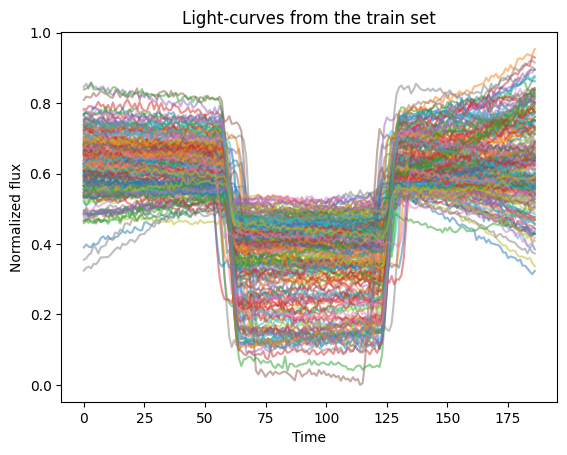

In [15]:
plt.figure()
for i in range(200):
    plt.plot(train_wc[-i], "-", alpha=0.5)
plt.title("Light-curves from the train set")
plt.xlabel("Time")
plt.ylabel("Normalized flux")
plt.show()

## Train 1D CNN

The model to estimate the mean of the target spectrum using the white light-curve is a 1D-CNN with Dropout layers to make a MC Dropout prediction.

This 1D CNN model is designed to predict the **mean flux** values across all 282 wavelengths, as represented by targets_mean for each observation, using the white curve as input data.

### Input: White Curve (673, 187)

The white curve provides a normalized temporal profile of the flux signal for each observation (673 observations in total), aggregated over spatial dimensions and wavelengths.

This temporal profile across 187 time steps serves as the input feature for each observation, focusing the model on how the flux changes over time while minimizing spectral details.


### Output: Targets Mean (673,)

The model aims to predict the mean flux across specific wavelengths (283 in total) for each observation, as captured in targets_mean.

This mean flux is computed from the targets matrix, which excludes the first column in the train_solution data. The first column likely represents a baseline flux measurement, while the remaining columns represent wavelength-specific flux measurements.

The target is thus an overall "mean" value that characterizes each observation’s flux level across these wavelengths.


### Purpose of the 1D CNN:

The 1D CNN is structured to capture patterns in the temporal signal of the white curve that correlate with the overall flux level across wavelengths.

By predicting the mean flux, the model may indirectly capture factors such as instrument calibration effects, environmental factors, or baseline shifts that impact the overall light intensity at a given observation time.

This prediction provides an efficient summary statistic, allowing scientists to quickly assess the average flux across wavelengths for each observation without needing to reconstruct the full wavelength-dependent signal.


### Why Mean Flux Prediction is Useful
Predicting the mean flux is beneficial because it:

- Reduces dimensionality from detailed spectral features to a single summary metric.
- Provides a normalized measure of light intensity across time for further analyses or comparisons.
- Can be used as a preliminary step in a more complex analysis pipeline, where the mean flux serves as an input feature or control variable.

In [16]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)

        # Define pooling and batch normalization layers
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 9, 500)  # Adjust the size based on flattened output
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)

        # Dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        # Apply convolution, pooling, and batch normalization layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)

        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the output from convolutional layers
        x = x.view(-1, 256 * 9)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

Creating DataLoader for wc training and validation data

In [17]:
# Create TensorDataset for training and validation data
train_dataset = TensorDataset(
    torch.tensor(train_wc, dtype=torch.float32),
    torch.tensor(train_targets_wc_norm, dtype=torch.float32),
)
valid_dataset = TensorDataset(
    torch.tensor(valid_wc, dtype=torch.float32),
    torch.tensor(valid_targets_wc_norm, dtype=torch.float32),
)

# Create DataLoader for training and validation data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

print(valid_loader.dataset.tensors[0].shape)
print(valid_loader.dataset.tensors[1].shape)

torch.Size([538, 187])
torch.Size([538])
torch.Size([135, 187])
torch.Size([135])


In [18]:
# Checkpoint saving function
def save_checkpoint(model, valid_loss, best_valid_loss, epoch, optimizer, output_dir):

    if valid_loss < best_valid_loss:

        print(
            f"Validation loss decreased from {best_valid_loss:.6f} to {valid_loss:.6f}."
        )

        best_valid_loss = valid_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": valid_loss,
            },
            output_dir + "/model_1d_cnn.pth",
        )

    return best_valid_loss


# Checkpoint loading function
def load_checkpoint(model_dir, model, optimizer):
    model_path = model_dir + "/model_1d_cnn.pth"

    if not os.path.exists(model_path):
        print("Checkpoint file does not exist. Training from scratch.")
        return model, optimizer, 0, float("inf")

    # Load the saved checkpoint
    checkpoint = torch.load(model_path, weights_only=False)

    # Restore model state
    model.load_state_dict(checkpoint["model_state_dict"])

    # Restore optimizer state
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    # Retrieve the epoch and loss information
    epoch = checkpoint["epoch"]
    valid_loss = checkpoint["loss"]

    print(f"Checkpoint loaded: Epoch {epoch}, Validation Loss {valid_loss:.4f}")

    return model, optimizer, epoch, valid_loss


# Training Loop
def train(
    model,
    train_loader,
    valid_loader,
    num_epochs,
    criterion,
    optimizer,
    scheduler,
    output_dir,
    device,
    best_valid_loss=float("inf"),
):
    print("Training started.")

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # 1. Training phase
        model.train()
        running_loss = 0.0

        train_progress = tqdm(train_loader)
        for x_train, y_train in train_progress:

            x_train, y_train = x_train.to(device), y_train.to(device)

            # Add channel dimension
            x_train, y_train = x_train.unsqueeze(1), y_train.unsqueeze(1)

            optimizer.zero_grad()

            # Forward pass
            output = model(x_train)
            loss = criterion(output, y_train)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_progress.set_description(f"Epoch {epoch+1}/{num_epochs}")
            train_progress.set_postfix({"loss": loss.item()})

        # Learning rate decay
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 2. Validation phase
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            valid_progress = tqdm(valid_loader)
            for x_valid, y_valid in valid_progress:

                x_valid, y_valid = x_valid.to(device), y_valid.to(device)

                # Add channel dimension
                x_valid, y_valid = x_valid.unsqueeze(1), y_valid.unsqueeze(1)

                valid_output = model(x_valid)
                valid_loss += criterion(valid_output, y_valid).item()

                valid_progress.set_description(
                    f"Validation Epoch {epoch+1}/{num_epochs}"
                )
                valid_progress.set_postfix(
                    {"valid_loss": valid_loss / len(valid_loader)}
                )

        # Average validation loss
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        # Save the best model checkpoint
        best_valid_loss = save_checkpoint(
            model, avg_valid_loss, best_valid_loss, epoch, optimizer, output_dir
        )

    print("Training completed.")

    # Save all train_losses and valid_losses of this training process
    np.save(output_dir + "/train_losses.npy", train_losses)
    np.save(output_dir + "/valid_losses.npy", valid_losses)

    return train_losses, valid_losses

In [19]:
num_epochs = 1200

model = CNNModel()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.2)

loss_fn = torch.nn.MSELoss()

best_valid_loss = float("inf")

Load or train model.

In [20]:
model, optimizer, epoch, best_valid_loss = load_checkpoint(output_dir, model, optimizer)

Checkpoint loaded: Epoch 495, Validation Loss 0.0010


In [20]:
train_losses, valid_losses = train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    num_epochs=num_epochs,
    criterion=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    output_dir=output_dir,
    device=device,
    best_valid_loss=best_valid_loss,
)

Training started.


Validation Epoch 1/1200: 100%|██████████| 3/3 [00:00<00:00, 160.98it/s, valid_loss=0.21]


Validation loss decreased from inf to 0.209724.


Validation Epoch 2/1200: 100%|██████████| 3/3 [00:00<00:00, 474.79it/s, valid_loss=0.204]


Validation loss decreased from 0.209724 to 0.204313.


Validation Epoch 3/1200: 100%|██████████| 3/3 [00:00<00:00, 347.58it/s, valid_loss=0.189]


Validation loss decreased from 0.204313 to 0.189216.


Validation Epoch 4/1200: 100%|██████████| 3/3 [00:00<00:00, 346.71it/s, valid_loss=0.161]


Validation loss decreased from 0.189216 to 0.161387.


Validation Epoch 5/1200: 100%|██████████| 3/3 [00:00<00:00, 478.47it/s, valid_loss=0.127]


Validation loss decreased from 0.161387 to 0.126674.


Validation Epoch 6/1200: 100%|██████████| 3/3 [00:00<00:00, 316.76it/s, valid_loss=0.0933]


Validation loss decreased from 0.126674 to 0.093284.


Validation Epoch 7/1200: 100%|██████████| 3/3 [00:00<00:00, 428.47it/s, valid_loss=0.0655]


Validation loss decreased from 0.093284 to 0.065544.


Validation Epoch 8/1200: 100%|██████████| 3/3 [00:00<00:00, 238.67it/s, valid_loss=0.0403]


Validation loss decreased from 0.065544 to 0.040282.


Validation Epoch 9/1200: 100%|██████████| 3/3 [00:00<00:00, 295.06it/s, valid_loss=0.0206]


Validation loss decreased from 0.040282 to 0.020603.


Validation Epoch 10/1200: 100%|██████████| 3/3 [00:00<00:00, 390.56it/s, valid_loss=0.00878]


Validation loss decreased from 0.020603 to 0.008776.


Validation Epoch 11/1200: 100%|██████████| 3/3 [00:00<00:00, 423.75it/s, valid_loss=0.00396]


Validation loss decreased from 0.008776 to 0.003957.


Validation Epoch 12/1200: 100%|██████████| 3/3 [00:00<00:00, 466.92it/s, valid_loss=0.00204]


Validation loss decreased from 0.003957 to 0.002040.


Validation Epoch 13/1200: 100%|██████████| 3/3 [00:00<00:00, 481.03it/s, valid_loss=0.00141]


Validation loss decreased from 0.002040 to 0.001411.


Validation Epoch 14/1200: 100%|██████████| 3/3 [00:00<00:00, 379.90it/s, valid_loss=0.00117]


Validation loss decreased from 0.001411 to 0.001172.


Validation Epoch 15/1200: 100%|██████████| 3/3 [00:00<00:00, 1447.64it/s, valid_loss=0.00083]


Validation loss decreased from 0.001172 to 0.000830.


Validation Epoch 16/1200: 100%|██████████| 3/3 [00:00<00:00, 495.84it/s, valid_loss=0.000803]


Validation loss decreased from 0.000830 to 0.000803.


Validation Epoch 17/1200: 100%|██████████| 3/3 [00:00<00:00, 514.32it/s, valid_loss=0.000799]


Validation loss decreased from 0.000803 to 0.000799.


Validation Epoch 18/1200: 100%|██████████| 3/3 [00:00<00:00, 410.62it/s, valid_loss=0.000785]


Validation loss decreased from 0.000799 to 0.000785.


Validation Epoch 20/1200: 100%|██████████| 3/3 [00:00<00:00, 423.44it/s, valid_loss=0.000772]


Validation loss decreased from 0.000785 to 0.000772.


Validation Epoch 22/1200: 100%|██████████| 3/3 [00:00<00:00, 343.66it/s, valid_loss=0.000769]


Validation loss decreased from 0.000772 to 0.000769.


Validation Epoch 23/1200: 100%|██████████| 3/3 [00:00<00:00, 242.01it/s, valid_loss=0.000708]


Validation loss decreased from 0.000769 to 0.000708.


Validation Epoch 24/1200: 100%|██████████| 3/3 [00:00<00:00, 314.64it/s, valid_loss=0.000687]


Validation loss decreased from 0.000708 to 0.000687.


Validation Epoch 25/1200: 100%|██████████| 3/3 [00:00<00:00, 464.18it/s, valid_loss=0.000665]


Validation loss decreased from 0.000687 to 0.000665.


Validation Epoch 27/1200: 100%|██████████| 3/3 [00:00<00:00, 425.62it/s, valid_loss=0.000636]


Validation loss decreased from 0.000665 to 0.000636.


Validation Epoch 32/1200: 100%|██████████| 3/3 [00:00<00:00, 457.05it/s, valid_loss=0.000618]


Validation loss decreased from 0.000636 to 0.000618.


Validation Epoch 33/1200: 100%|██████████| 3/3 [00:00<00:00, 469.86it/s, valid_loss=0.000613]


Validation loss decreased from 0.000618 to 0.000613.


Validation Epoch 34/1200: 100%|██████████| 3/3 [00:00<00:00, 500.02it/s, valid_loss=0.000602]


Validation loss decreased from 0.000613 to 0.000602.


Validation Epoch 36/1200: 100%|██████████| 3/3 [00:00<00:00, 531.13it/s, valid_loss=0.000585]


Validation loss decreased from 0.000602 to 0.000585.


Validation Epoch 37/1200: 100%|██████████| 3/3 [00:00<00:00, 498.89it/s, valid_loss=0.000553]


Validation loss decreased from 0.000585 to 0.000553.


Validation Epoch 39/1200: 100%|██████████| 3/3 [00:00<00:00, 584.84it/s, valid_loss=0.000549]


Validation loss decreased from 0.000553 to 0.000549.


Validation Epoch 48/1200: 100%|██████████| 3/3 [00:00<00:00, 477.53it/s, valid_loss=0.000537]


Validation loss decreased from 0.000549 to 0.000537.


Validation Epoch 49/1200: 100%|██████████| 3/3 [00:00<00:00, 909.30it/s, valid_loss=0.000494]


Validation loss decreased from 0.000537 to 0.000494.


Validation Epoch 51/1200: 100%|██████████| 3/3 [00:00<00:00, 522.94it/s, valid_loss=0.000491]


Validation loss decreased from 0.000494 to 0.000491.


Validation Epoch 69/1200: 100%|██████████| 3/3 [00:00<00:00, 428.89it/s, valid_loss=0.000487]


Validation loss decreased from 0.000491 to 0.000487.


Validation Epoch 79/1200: 100%|██████████| 3/3 [00:00<00:00, 281.81it/s, valid_loss=0.000472]


Validation loss decreased from 0.000487 to 0.000472.


Validation Epoch 90/1200: 100%|██████████| 3/3 [00:00<00:00, 741.65it/s, valid_loss=0.000471]


Validation loss decreased from 0.000472 to 0.000471.


Validation Epoch 95/1200: 100%|██████████| 3/3 [00:00<00:00, 575.17it/s, valid_loss=0.00047]


Validation loss decreased from 0.000471 to 0.000470.


Validation Epoch 100/1200: 100%|██████████| 3/3 [00:00<00:00, 485.85it/s, valid_loss=0.000462]


Validation loss decreased from 0.000470 to 0.000462.


Validation Epoch 105/1200: 100%|██████████| 3/3 [00:00<00:00, 318.70it/s, valid_loss=0.000459]


Validation loss decreased from 0.000462 to 0.000459.


Validation Epoch 130/1200: 100%|██████████| 3/3 [00:00<00:00, 527.36it/s, valid_loss=0.000458]


Validation loss decreased from 0.000459 to 0.000458.


Validation Epoch 138/1200: 100%|██████████| 3/3 [00:00<00:00, 912.20it/s, valid_loss=0.000454]


Validation loss decreased from 0.000458 to 0.000454.


Validation Epoch 149/1200: 100%|██████████| 3/3 [00:00<00:00, 518.31it/s, valid_loss=0.000453]


Validation loss decreased from 0.000454 to 0.000453.


Validation Epoch 177/1200: 100%|██████████| 3/3 [00:00<00:00, 331.67it/s, valid_loss=0.000452]


Validation loss decreased from 0.000453 to 0.000452.


Validation Epoch 182/1200: 100%|██████████| 3/3 [00:00<00:00, 644.68it/s, valid_loss=0.000451]


Validation loss decreased from 0.000452 to 0.000451.


Validation Epoch 376/1200: 100%|██████████| 3/3 [00:00<00:00, 1188.64it/s, valid_loss=0.00045]


Validation loss decreased from 0.000451 to 0.000450.


Validation Epoch 377/1200: 100%|██████████| 3/3 [00:00<00:00, 456.78it/s, valid_loss=0.000449]


Validation loss decreased from 0.000450 to 0.000449.


Validation Epoch 1200/1200: 100%|██████████| 3/3 [00:00<00:00, 443.56it/s, valid_loss=0.000539]

Training completed.


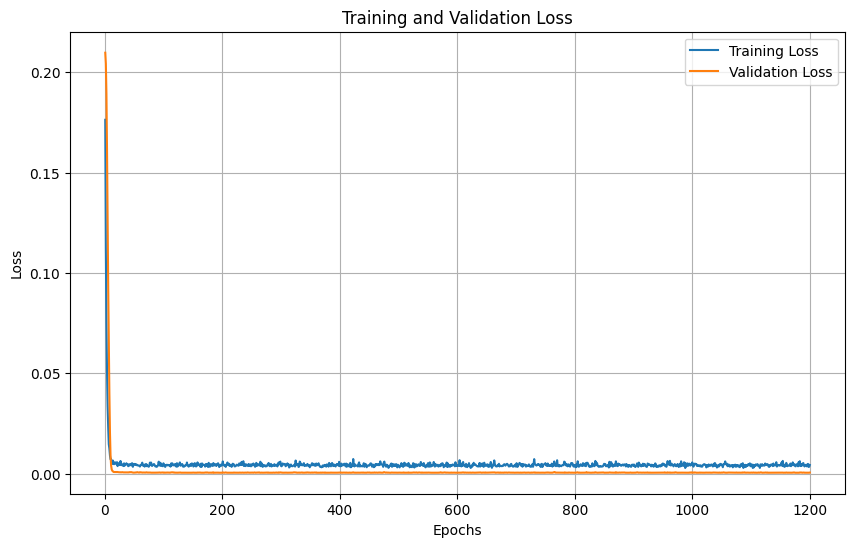

In [21]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(output_dir + "/training_validation_loss.png")
plt.show()

## 1D CNN Inference

Then, we perform the MC Dropout to obtain the mean prediction and the uncertainty associated. We choose to compute 1000 instances.

In [30]:
nb_dropout_wc = 1000


def unstandardizing(data, min_train_valid, max_train_valid):
    return data * (max_train_valid - min_train_valid) + min_train_valid


def MC_dropout_WC(model, data_loader, nb_dropout, device):
    """
    Monte Carlo dropout is used to estimate the uncertainty of the model's predictions
    by performing multiple forward passes with dropout enabled.

    """
    model.train()  # Ensure dropout is enabled during inference
    all_predictions = []

    for _ in range(nb_dropout):
        predictions = []

        with torch.no_grad():  # Disable gradient computation
            for x_valid, _ in data_loader:

                x_valid = x_valid.to(device)

                # Add channel dimension
                x_valid = x_valid.unsqueeze(1)

                # Forward pass
                output = model(x_valid)
                predictions.append(output.cpu().numpy().flatten())
                # length of predictions: 135 (number of validation samples)

        # Stack predictions for this dropout run and append to all_predictions
        all_predictions.append(np.concatenate(predictions, axis=0))

    return np.array(all_predictions)


if do_the_mcdropout_wc:
    print("Running ...")

    prediction_valid_wc = MC_dropout_WC(model, valid_loader, nb_dropout_wc, device)
    spectre_valid_wc_all = unstandardizing(
        prediction_valid_wc, min_train_valid_wc, max_train_valid_wc
    )

    spectre_valid_wc = spectre_valid_wc_all.mean(axis=0)
    spectre_valid_std_wc = spectre_valid_wc_all.std(axis=0)

    print("Done.")

    print("prediction_valid_wc.shape", prediction_valid_wc.shape)
    print("spectre_valid_wc_all.shape", spectre_valid_wc_all.shape)

    print("spectre_valid_wc.shape", spectre_valid_wc.shape)
    print("spectre_valid_std_wc.shape", spectre_valid_std_wc.shape)

Running ...
Done.
prediction_valid_wc.shape (1000, 135)
spectre_valid_wc_all.shape (1000, 135)
spectre_valid_wc.shape (135,)
spectre_valid_std_wc.shape (135,)


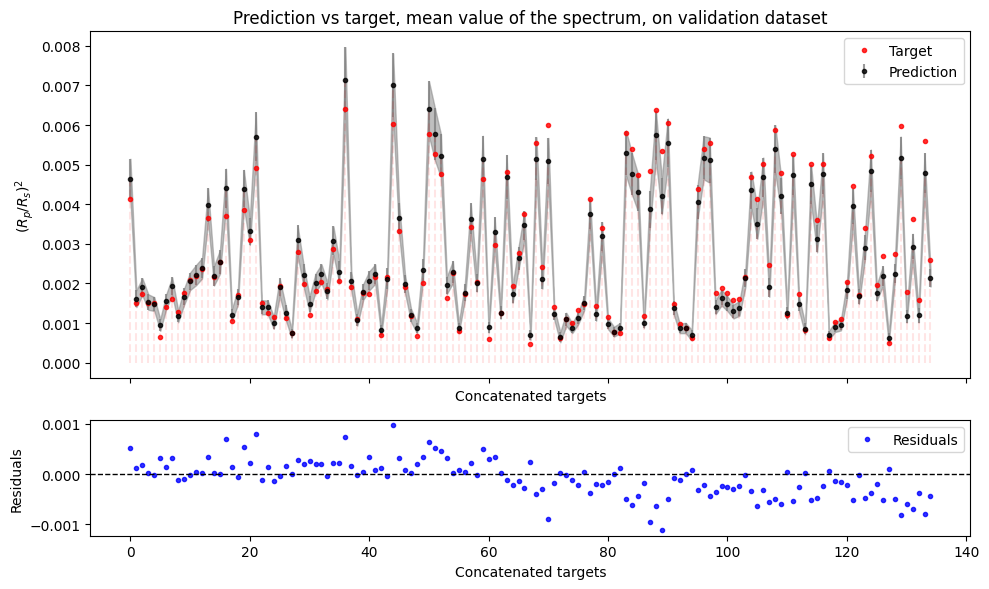

In [23]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

ax1.errorbar(
    x=np.arange(len(spectre_valid_wc)),
    y=spectre_valid_wc,
    yerr=spectre_valid_std_wc,
    fmt=".",
    color="k",
    ecolor="gray",
    label="Prediction",
    alpha=0.8,
)
ax1.fill_between(
    np.arange(len(spectre_valid_wc)),
    spectre_valid_wc - spectre_valid_std_wc,
    spectre_valid_wc + spectre_valid_std_wc,
    color="grey",
    alpha=0.5,
)
ax1.vlines(
    np.arange(len(spectre_valid_wc)),
    ymin=0,
    ymax=spectre_valid_wc,
    colors="r",
    linestyle="dashed",
    alpha=0.1,
)
ax1.plot(valid_targets_wc, "r.", label="Target", alpha=0.8)
ax1.set_xlabel("Concatenated targets")
ax1.set_ylabel("$(R_p/R_s)^2$")
ax1.set_title("Prediction vs target, mean value of the spectrum, on validation dataset")
ax1.legend()

ax2.plot(residuals, "b.", label="Residuals", alpha=0.8)
ax2.set_xlabel("Concatenated targets")
ax2.set_ylabel("Residuals")
ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
residuals = valid_targets_wc - spectre_valid_wc
print("MSE : ", np.sqrt((residuals**2).mean()) * 1e6, "ppm")

# TODO: MSE larger than baseline model

MSE :  367.83224103057455 ppm


In [25]:
np.save(f'{output_dir}/pred_valid_wc.npy', spectre_valid_wc)
np.save(f'{output_dir}/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/std_valid_wc.npy', spectre_valid_std_wc)

# 2D CNN for atmospheric features

<a id="fluctu"></a>
We now remove the mean value (transit depth) of the spectra to keep the atmospheric features only

## Preprocessing for 2D CNN

In [40]:
def suppress_mean(targets, mean):
    res = targets - np.repeat(
        mean.reshape((mean.shape[0], 1)), repeats=targets.shape[1], axis=1
    )
    return res


# TODO: why squashing and concatenating the FGS column to the AIRS data match the length of the targets (283)
# which cuts the first element from the 'train_labels.csv' file?
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

train_targets_shift = suppress_mean(train_targets, targets_mean[list_index_train])
valid_targets_shift = suppress_mean(valid_targets, targets_mean[~list_index_train])

print("train_targets.shape", train_targets.shape)
print("valid_targets.shape", valid_targets.shape)
print("targets_mean.shape", targets_mean.shape)
print("train_targets_shift.shape", train_targets_shift.shape)
print("valid_targets_shift.shape", valid_targets_shift.shape)

train_targets.shape (538, 283)
valid_targets.shape (135, 283)
targets_mean.shape (673,)
train_targets_shift.shape (538, 283)
valid_targets_shift.shape (135, 283)


We normalize the targets so that they range between -1 and 1, centered on zero

In [26]:
##### normalization of the targets ###
def targets_normalization(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1 / data_abs_max
    data2 = data2 / data_abs_max
    return data1, data2, data_abs_max


def targets_norm_back(data, data_abs_max):
    return data * data_abs_max


train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(
    train_targets_shift, valid_targets_shift
)

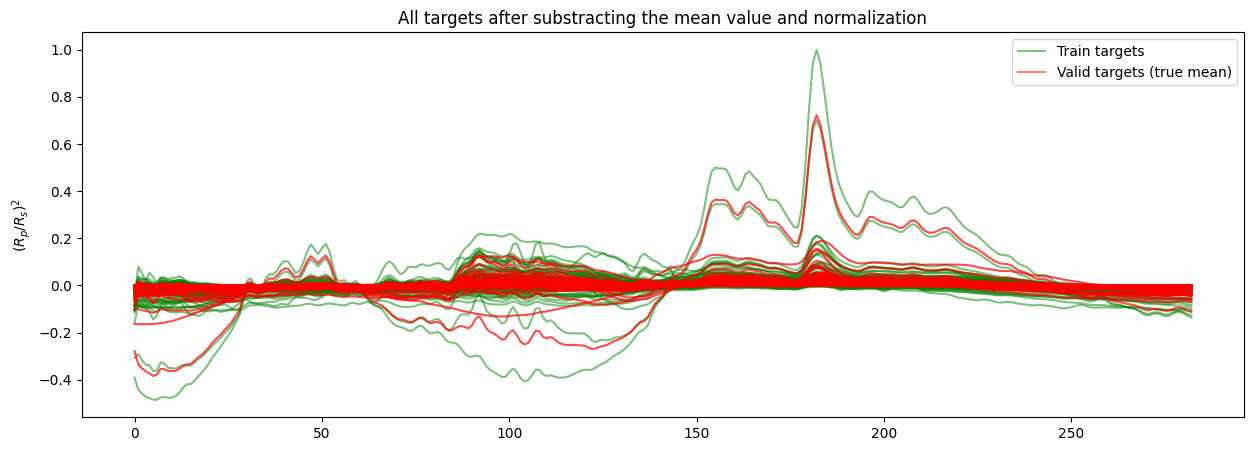

In [27]:
plt.figure(figsize=(15, 5))

for i in range(240):
    plt.plot(wls, train_targets_norm[i], "g-", alpha=0.5)
plt.plot([], [], "g-", alpha=0.5, label="Train targets")
for i in range(60):
    plt.plot(wls, valid_targets_norm[i], "r-", alpha=0.7)
plt.plot([], [], "r-", alpha=0.5, label="Valid targets (true mean)")

plt.legend()
plt.ylabel(f"$(R_p/R_s)^2$")
plt.title("All targets after subtracting the mean value and normalization")
plt.show()

In [28]:
###### Transpose #####
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape)

(538, 187, 283)


We cut the transit to keep the in-transit. We assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.

In [29]:
##### Subtracting the out transit signal #####
def suppress_out_transit(data, ingress, egress):
    data_in = data[:, ingress:egress, :]
    return data_in


ingress, egress = 75, 115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)

We remove the mean value of the in-transit to get relative data like the targets

In [30]:
###### Subtract the mean #####
def subtract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean


train_obs_2d_mean = subtract_data_mean(train_obs_in)
valid_obs_2d_mean = subtract_data_mean(valid_obs_in)

We use the same normalization as for the targets, i.e. between -1 and 1 centered on zero

In [31]:
##### Normalization dataset #####
def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1 / data_abs_max
    data2 = data2 / data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max):
    return data * data_abs_max


train_obs_norm, valid_obs_norm, data_abs_max = data_norm(
    train_obs_2d_mean, valid_obs_2d_mean
)

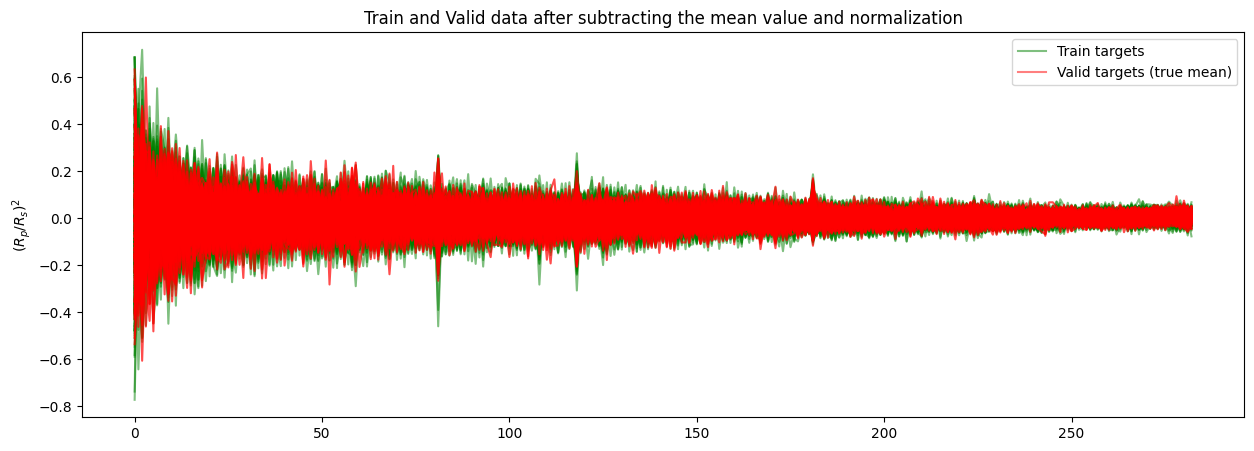

In [32]:
plt.figure(figsize=(15, 5))
for i in range(train_obs.shape[0]):
    plt.plot(wls, train_obs_norm[i, 10], "g-", alpha=0.5)
plt.plot([], [], "g-", alpha=0.5, label="Train targets")
for i in range(valid_obs.shape[0]):
    plt.plot(wls, valid_obs_norm[i, 10], "r-", alpha=0.7)
plt.plot([], [], "r-", alpha=0.5, label="Valid targets (true mean)")

plt.legend()
plt.ylabel(f"$(R_p/R_s)^2$")
plt.title("Train and Valid data after subtracting the mean value and normalization")
plt.show()

## Train 2D CNN

In [28]:
from tensorflow import keras
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
    Reshape,
    Dropout,
    BatchNormalization,
    AveragePooling2D,
)
from keras.models import Model
import tensorflow as tf
import numpy as np

## CNN 2 global normalization data
input_obs = Input((40, 283, 1))
x = Conv2D(32, (3, 1), activation="relu", padding="same")(input_obs)
x = MaxPooling2D((2, 1))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 1), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(128, (3, 1), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 1))(x)
x = Conv2D(256, (3, 1), activation="relu", padding="same")(x)
x = Conv2D(32, (1, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((1, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(128, (1, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((1, 2))(x)
x = Conv2D(256, (1, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((1, 2))(x)
x = Flatten()(x)
# DNN
x = Dense(700, activation="relu")(x)
x = Dropout(0.2)(x, training=True)
output = Dense(283, activation="linear")(x)

model = Model(inputs=[input_obs], outputs=output)

checkpoint_filepath = "output/model_2dcnn.keras"
model_ckt2 = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)
model.compile(optimizer=Adam(0.001), loss="mse", metrics=[MeanAbsoluteError()])
model.summary()

In [29]:
history = model.fit(
    x=train_obs_norm,
    y=train_targets_norm,
    validation_data=(valid_obs_norm, valid_targets_norm),
    batch_size=32,
    epochs=200,
    shuffle=True,
    verbose=0,
    callbacks=[model_ckt2],
)

## Postprocessing and visualisation

We obtain uncertainties on the predictions by computing a MCDropout.

In [30]:
nb_dropout = 5


def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model.predict([x_test], verbose=0)
        pred = targets_norm_back(pred_norm, targets_abs_max)
        predictions += [pred]
    mean, std = np.mean(np.array(predictions), axis=0), np.std(
        np.array(predictions), axis=0
    )
    return mean, std


if do_the_mcdropout:
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainity(
        model, [valid_obs_norm], targets_abs_max, T=nb_dropout
    )

else:

    pred_valid_norm = model.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift = pred_valid
    spectre_valid_shift_std = spectre_valid_shift * 0.1

In [31]:
residuals = valid_targets_shift - spectre_valid_shift
print("MSE : ", np.sqrt((residuals**2).mean()) * 1e6, "ppm")

In [32]:
# np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
# np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
# np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)

In [33]:
plt.figure()
for i in range(50):
    plt.plot(spectre_valid_shift[-i] + 0.0001 * i, "-", alpha=0.5)
plt.title("Spectra predictions for the validation set")
plt.xlabel("Time")
plt.ylabel("Arbitrary flux")
plt.show()

In [34]:
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt(
    "/kaggle/input/ariel-data-challenge-2024/wavelengths.csv", skiprows=1, delimiter=","
)
uncertainty = spectre_valid_shift_std
for i in list_valid_planets:
    plt.figure()
    plt.title("Result for the sample {} of the validation set".format(i))
    plt.plot(wavelength, spectre_valid_shift[i], ".k", label="Prediction")
    plt.plot(wavelength, valid_targets_shift[i], color="tomato", label="Target")
    plt.fill_between(
        wavelength,
        spectre_valid_shift[i] - spectre_valid_shift_std[i],
        spectre_valid_shift[i] + spectre_valid_shift_std[i],
        color="silver",
        alpha=0.8,
        label="Uncertainty",
    )
    plt.legend()
    plt.ylabel(f"$(R_p/R_s)^2$")
    plt.xlabel(f"Wavelength ($\mu$m)")
    plt.show()

# Combine 1D and 2D CNN output for FINAL SPECTRA 

In [35]:
######## ADD THE FLUCTUATIONS TO THE MEAN ########
def add_the_mean(shift, mean):
    return shift + mean[:, np.newaxis]


predictions_valid = add_the_mean(spectre_valid_shift, spectre_valid_wc)

predictions_std_valid = np.sqrt(
    spectre_valid_std_wc[:, np.newaxis] ** 2 + spectre_valid_shift_std**2
)

In [36]:
uncertainty = predictions_std_valid


def plot_one_sample_valid(ax, p):
    ax.set_title(f"Result for sample {p} ")
    (line1,) = ax.plot(wavelength, predictions_valid[p], ".k", label="Prediction")
    (line2,) = ax.plot(wavelength, valid_targets[p], color="tomato", label="Target")
    ax.fill_between(
        wavelength,
        predictions_valid[p, :] - uncertainty[p],
        predictions_valid[p, :] + uncertainty[p],
        color="silver",
        alpha=0.8,
        label="Uncertainty",
    )
    ax.set_ylabel(f"$(R_p/R_s)^2$")
    ax.set_xlabel(f"Wavelength ($\mu$m)")
    return line1, line2


num_samples = 16
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
samples = [1, 2, 7, 15, 20, 25, 30, 35, 40, 45, 50, 55, 6, 5, 8, 9]
lines = []

for i, ax in enumerate(axs.flat):
    lines.extend(plot_one_sample_valid(ax, samples[i]))

fig.legend(
    lines[:2],
    ["Prediction", "Target"],
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.05),
)
fig.suptitle("Validation dataset")
plt.tight_layout()
plt.show()

In [37]:
######## PLOTS THE RESULT ########
predictions = predictions_valid
targets_plot = valid_targets
std = predictions_std_valid

predictions_concatenated_plot = np.concatenate(predictions, axis=0)
wls_concatenated = np.arange(predictions_concatenated_plot.shape[0])
targets_concatenated_plot = np.concatenate(targets_plot, axis=0)
spectre_valid_std_concatenated = np.concatenate(std, axis=0)
residuals = targets_concatenated_plot - predictions_concatenated_plot
uncertainty = spectre_valid_std_concatenated

fig, axs = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={"height_ratios": [3, 1]})


axs[0].plot(
    wls_concatenated, predictions_concatenated_plot, "-", color="k", label="Prediction"
)
axs[0].plot(
    wls_concatenated, targets_concatenated_plot, "-", color="tomato", label="Target"
)
axs[0].fill_between(
    np.arange(len(wls_concatenated)),
    predictions_concatenated_plot - uncertainty,
    predictions_concatenated_plot + uncertainty,
    color="silver",
    alpha=1,
    label="Uncertainty",
)
axs[0].set_xlabel("Concatenated wavelengths for all planets")
axs[0].set_ylabel(f"$(R_p/R_s)^2$")
axs[0].set_title("Prediction vs target, validation dataset")
axs[0].legend()

axs[1].plot(wls_concatenated, residuals, "-", color="cornflowerblue", label="Residual")
axs[1].fill_between(
    np.arange(len(wls_concatenated)),
    residuals - uncertainty,
    residuals + uncertainty,
    color="lightblue",
    alpha=0.9,
    label="Uncertainty",
)
axs[1].set_xlabel("Concatenated wavelengths for all planets")
axs[1].set_ylabel("Residual")
axs[1].set_title("Residuals with Uncertainty")
axs[1].legend()

plt.tight_layout()
plt.show()

print("MSE : ", np.sqrt((residuals**2).mean()) * 1e6, "ppm")

In [38]:
# np.save(f'{output_dir}/pred_valid.npy', predictions_valid)
# np.save(f'{output_dir}/std_valid.npy', predictions_std_valid)